# Stroke Prediction

Group 14
Group member: Xichen Liu, Duo Zhao, Keming Xu, Wenshu Yang, Rodolph Mesadieu

In [ ]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesClassifier

import warnings
warnings.filterwarnings('ignore')

## Data Pre-processing

Read data and general view

In [98]:
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv')
print(f'Shape of dataset: {stroke_data.shape}')
stroke_data.head()

Shape of dataset: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


*Feature description:*
> * **id**: Unique identifier
> * **gender**: Male, Female, or Other
> * **age**: Age of the patient
> * **hypertension**: If the patient has hypertension
> * **heart_disease**: If the patient has any heart diseases
> * **ever_married**: If the patient has ever get married
> * **work_type**: Types of patients' jobs
> * **Residence_type**: Residence regions
> * **avg_glucose**: Average glucose level in blood
> * **bmi**: Body mass index
> * **smoking_status**: Frequency of smoking
> * **stroke**: If the patient has stroke.

##### Missing values

In [99]:
print('Missing values in each features:')
print(stroke_data.isna().sum())

Missing values in each features:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Fill out the missing values

In [100]:
DT_bmi_pipe = Pipeline(steps=[
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state = 42))
                              ])
X = stroke_data[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male': 0,'Female': 1,'Other': -1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index = Missing.index)
stroke_data.loc[Missing.index,'bmi'] = predicted_bmi
print('Missing values in each features:')
print(stroke_data.isna().sum())

Missing values in each features:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


##### Duplicates

In [101]:
print(f'Duplicates in dataset: {stroke_data.duplicated().sum()} ({np.round(100 * stroke_data.duplicated().sum() / len(stroke_data), 2)}%)')

Duplicates in dataset: 0 (0.0%)


##### Cardinality of features

In [102]:
stroke_data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   528
smoking_status          4
stroke                  2
dtype: int64

Except targets, we got 7 categorical features, 3 continuous features, and 1 qualitative feature(id)

##### Data types

In [103]:
stroke_data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

We will need to transform the object data to be numeric so that we can train models

##### Encode the categorical features

In [104]:
encoder = LabelEncoder()
encoded_stroke_data = stroke_data.apply(encoder.fit_transform)
encoded_stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,671,1,88,0,1,1,2,1,3850,349,1,1
1,3610,0,82,0,0,1,3,0,3588,215,2,1
2,2151,1,101,0,1,1,2,0,2483,294,2,1
3,4226,0,70,0,0,1,2,1,3385,325,3,1
4,114,0,100,1,0,1,3,0,3394,127,2,1


## Exploratory data analysis(EDA)

##### Target distribution

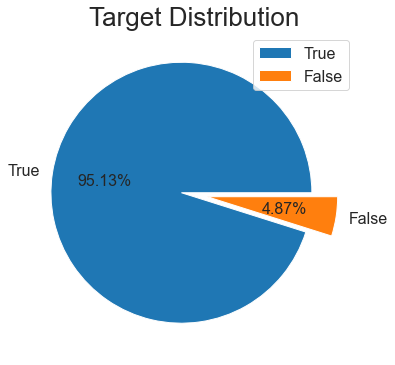

In [105]:
plt.figure(figsize = (6, 6))
plt.pie(stroke_data['stroke'].value_counts(), explode = [0.1, 0.1], labels = ['True', 'False'], autopct = '%.2f%%', shadow = False, textprops = {'fontsize': 16})
plt.title('Target Distribution', fontsize = 26)
plt.legend(prop = {'size': 16})
plt.show()

Distribution is not even, may need under sampling or over sampling

##### Continuous features

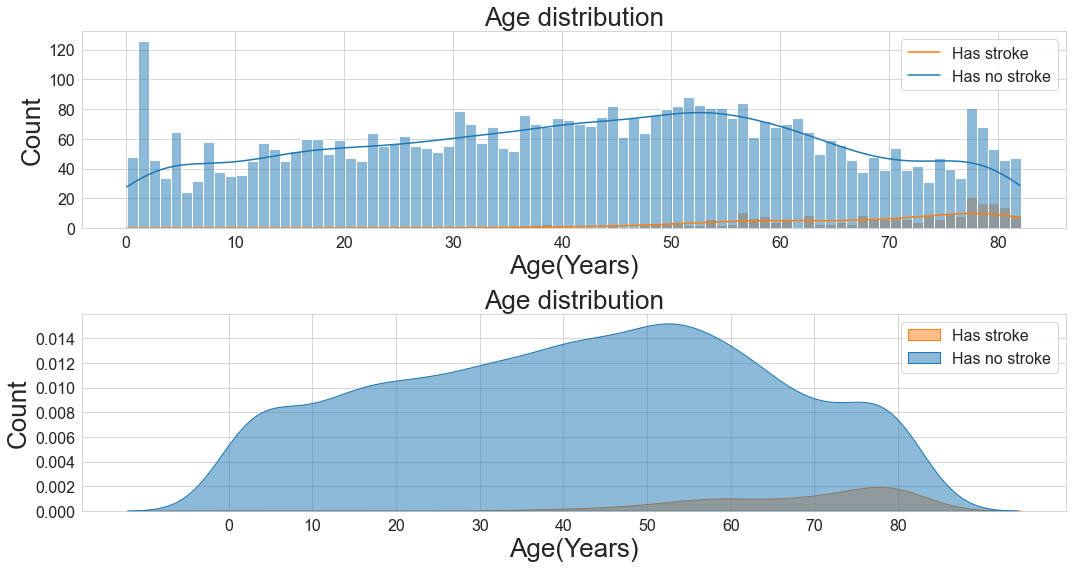

In [106]:
age_dis = plt.figure(figsize = (15, 8))

ax = age_dis.add_subplot(2, 1, 1)
sns.histplot(data = stroke_data, x = 'age', axes = ax, hue = 'stroke', binwidth = 1, kde = True)
plt.legend(labels = ['Has stroke', 'Has no stroke'], prop = {'size': 16})
plt.title('Age distribution', fontsize = 26)
plt.xlabel('Age(Years)', fontsize = 26)
plt.xticks(np.arange(0, 90, 10), fontsize = 16)
plt.ylabel('Count', fontsize = 26)
plt.yticks(fontsize = 16)

ax = age_dis.add_subplot(2, 1, 2)
sns.kdeplot(data = stroke_data, x = 'age', axes = ax, hue = 'stroke', shade  = True, alpha = 0.5)
plt.legend(labels = ['Has stroke', 'Has no stroke'], prop = {'size': 16})
plt.title('Age distribution', fontsize = 26)
plt.xlabel('Age(Years)', fontsize = 26)
plt.xticks(np.arange(0, 90, 10), fontsize = 16)
plt.ylabel('Count', fontsize = 26)
plt.yticks(fontsize = 16)

age_dis.tight_layout()
plt.show()

Easy to find out that:
Patients under 40 years old barely have stroke
A small portion of patients from 40 to 65 years old have stroke
A greater percentage of patients over 70 years old have stroke
So we may divide the age feature into three groups

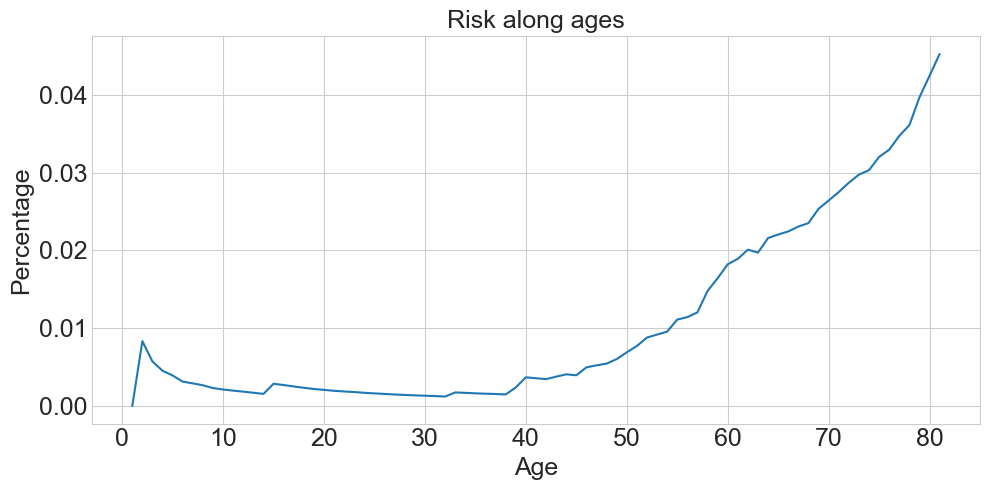

In [107]:
# Risk of getting stroke along age
stroke_data['age'] = stroke_data['age'].astype(int)

stroke_risk_age = plt.figure(figsize = (10, 5), dpi = 100)
rate = []
for i in range(stroke_data['age'].min(), stroke_data['age'].max()):
    rate.append(stroke_data[stroke_data['age'] < i]['stroke'].sum() / len(stroke_data[stroke_data['age'] < i]['stroke']))

sns.lineplot(data = rate)
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.tick_params(axis = u'both', which = u'both',length = 0)
plt.title('Risk along ages', fontsize = 18)
plt.xlabel('Age', fontsize = 18)
plt.ylabel('Percentage', fontsize = 18)

stroke_risk_age.tight_layout()
plt.show()

Risk of getting stroke increases as age increases.

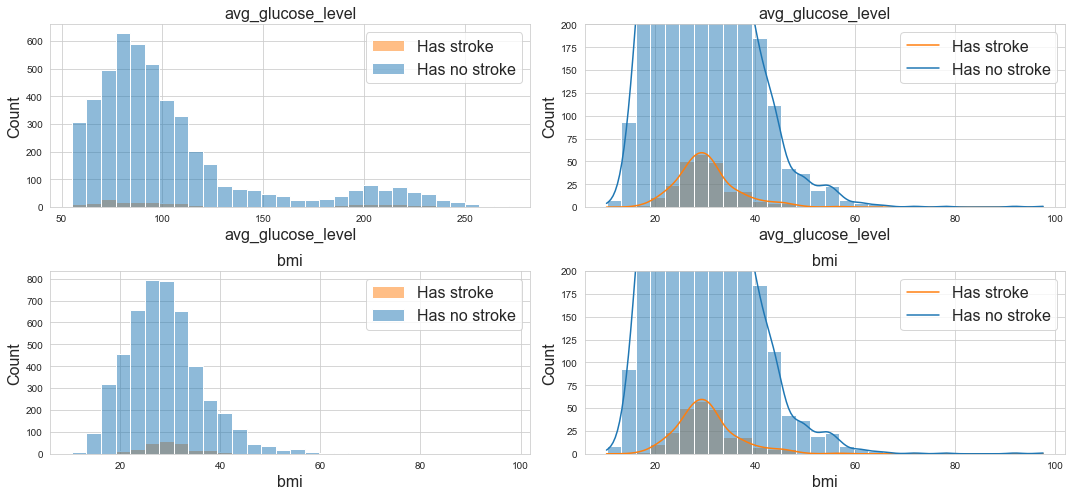

In [108]:
# Glucose and bmi
glu_bmi = ['avg_glucose_level', 'bmi']

fig_glu_bmi = plt.figure(figsize = (15, 7))
for i, var in enumerate(glu_bmi):
    ax = fig_glu_bmi.add_subplot(2, 2, 2 * i + 1)
    sns.histplot(data = stroke_data, x = var, axes = ax, hue = 'stroke', kde = False, bins = 30)
    ax.set_title(var, fontdict = {'fontsize': 16})
    ax.legend(labels = ['Has stroke', 'Has no stroke'], prop = {'size': 16})
    ax.set_xlabel(var, fontdict = {'fontsize': 16})
    ax.set_ylabel('Count', fontdict = {'fontsize': 16})

    ax = fig_glu_bmi.add_subplot(2, 2, 2 * i + 2)
    sns.histplot(data = stroke_data, x = 'bmi', axes = ax, hue = 'stroke', kde = True, bins = 30)
    ax.set_title(var, fontsize = 16)
    ax.legend(labels = ['Has stroke', 'Has no stroke'], prop = {'size': 16})
    ax.set_xlabel(var, fontdict = {'fontsize': 16})
    ax.set_ylabel('Count', fontdict = {'fontsize': 16})
    ax.set_ylim([0, 200])

fig_glu_bmi.tight_layout()
plt.show()

The general distribution of the whether a patient has stroke or not relates to average glucose level and bmi are similar.
In other words, they can be combined into one feature.

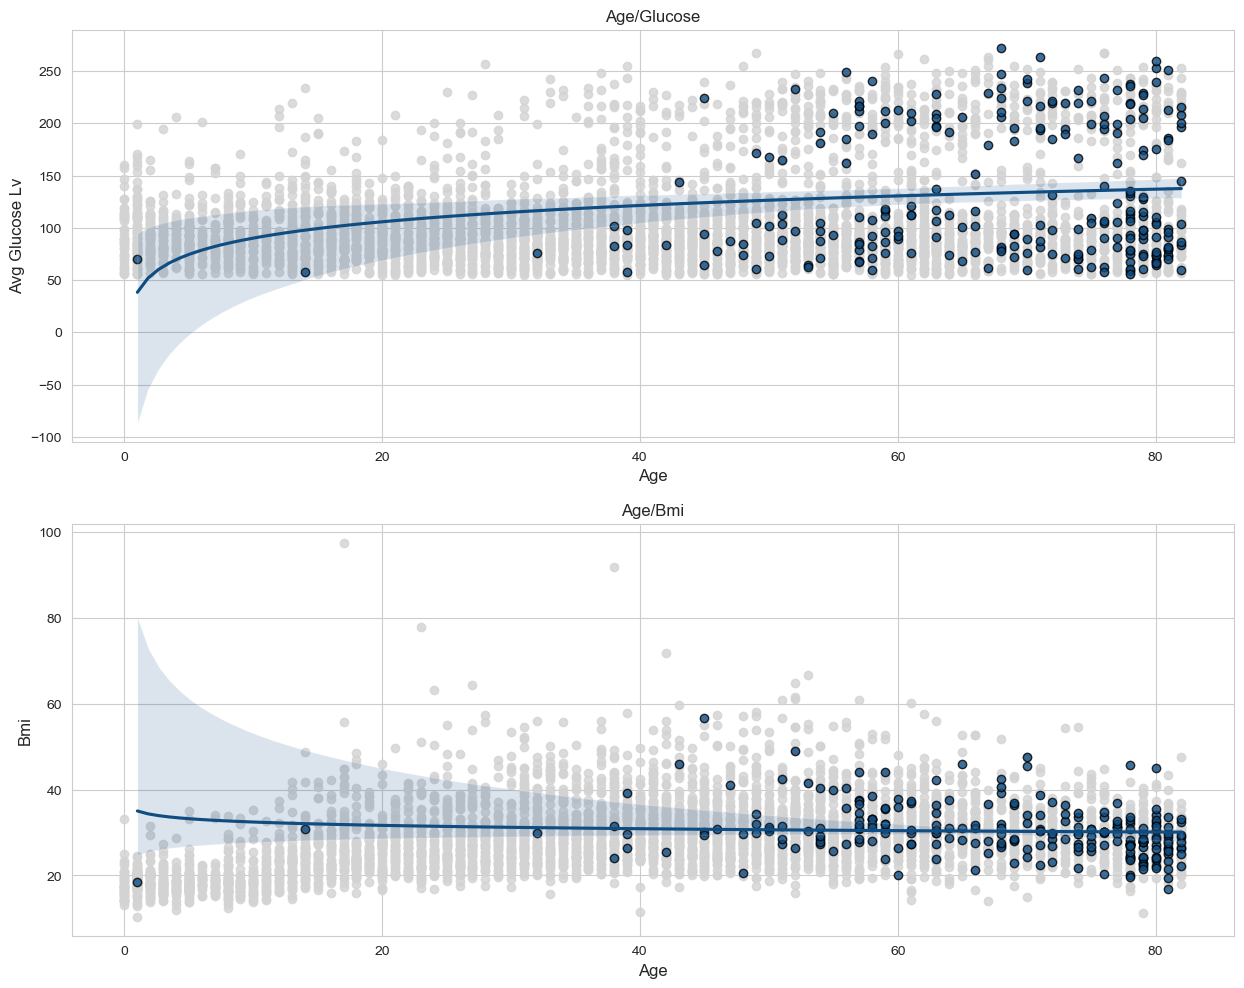

In [109]:
# Age and glucose/bmi

str_only = stroke_data[stroke_data['stroke'] == 1]
no_str_only = stroke_data[stroke_data['stroke'] == 0]

fig_age_glu_bmi = plt.figure(figsize = (15, 12), dpi = 100)

ax = fig_age_glu_bmi.add_subplot(2, 1, 1)
sns.regplot(data = no_str_only, x = no_str_only['age'], y = no_str_only['avg_glucose_level'], color = 'lightgray', logx = True, ax = ax)
sns.regplot(data = str_only, x = str_only['age'], y = str_only['avg_glucose_level'], color = '#0f4c81', logx = True, scatter_kws = {'edgecolors':['black'], 'linewidth': 1}, ax = ax)
ax.set_title('Age/Glucose', fontsize = 12)
ax.set_xlabel('Age', fontsize = 12)
ax.set_ylabel('Avg Glucose Lv', fontsize = 12)

ax = fig_age_glu_bmi.add_subplot(2, 1, 2)
sns.regplot(data = no_str_only, x = no_str_only['age'], y = no_str_only['bmi'], color = 'lightgray', logx = True, ax = ax)
sns.regplot(data = str_only, x = str_only['age'], y = str_only['bmi'], color = '#0f4c81', logx = True, scatter_kws = {'edgecolors':['black'], 'linewidth': 1}, ax = ax)
ax.set_title('Age/Bmi', fontsize = 12)
ax.set_xlabel('Age', fontsize = 12)
ax.set_ylabel('Bmi', fontsize = 12)

plt.show()

We can find that having stroke or not depends on age feature so much

##### Categorical features

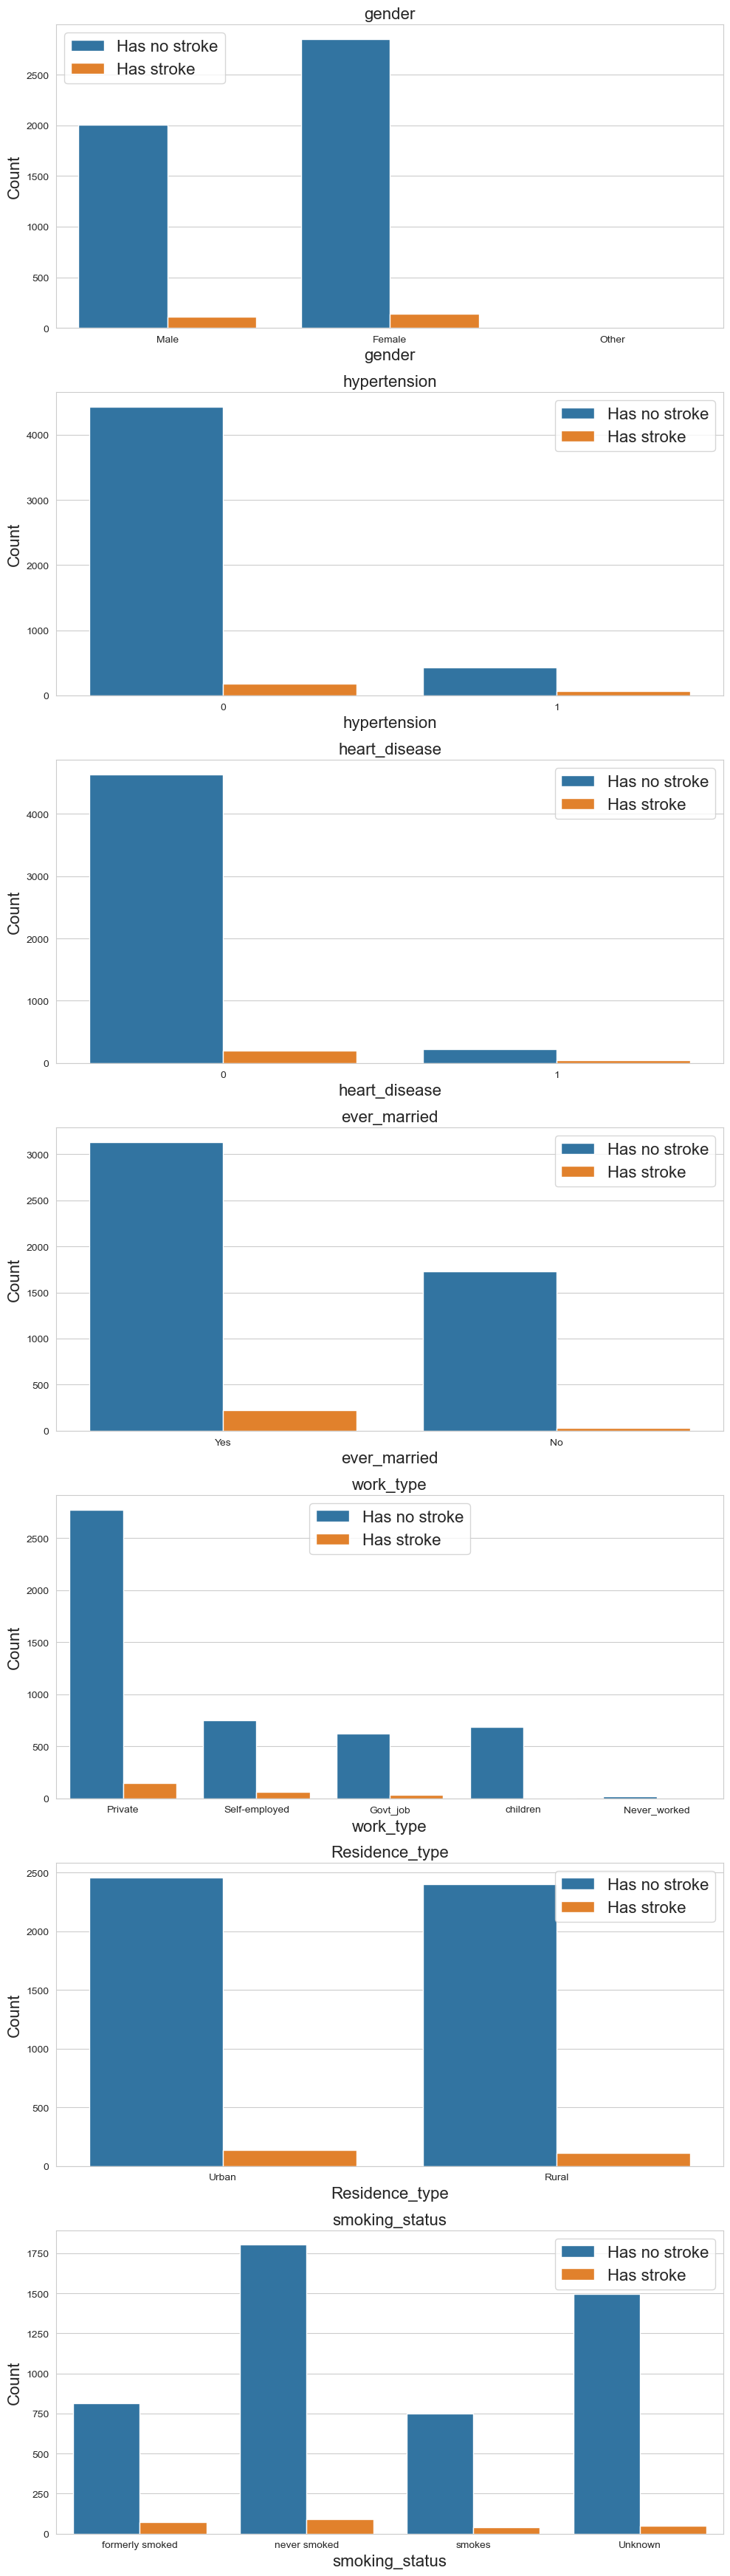

In [110]:
cat_fea = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
fig_cat = plt.figure(figsize = (10, 35), dpi = 100)
for i, var in enumerate(cat_fea):
    ax = fig_cat.add_subplot(7, 1, i + 1)
    sns.countplot(data = stroke_data, x = var, axes = ax, hue = 'stroke')
    ax.set_title(var, fontdict = {'fontsize': 16})
    ax.legend(labels = ['Has no stroke', 'Has stroke'], prop = {'size': 16})
    ax.set_xlabel(var, fontdict = {'fontsize': 16})
    ax.set_ylabel('Count', fontdict = {'fontsize': 16})
fig_cat.tight_layout()
plt.show()

##### Feature relations

In [111]:
# A general view
fig_gen_view = px.parallel_categories(stroke_data[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
                                                   'work_type', 'Residence_type', 'smoking_status', 'stroke']],
                                      color = 'stroke', color_continuous_scale = px.colors.sequential.Darkmint)
fig_gen_view.show()

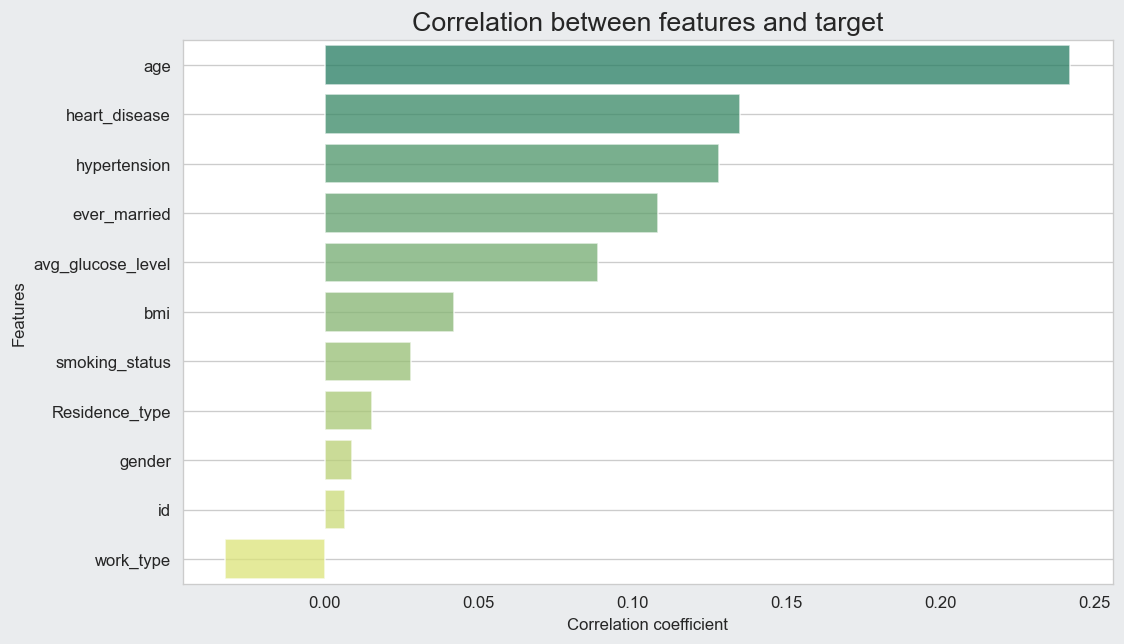

In [112]:
# Correlation between features and target
features = list(stroke_data.columns)[:-1]

correlation_table = []
for cols in features:
    y = encoded_stroke_data["stroke"]
    x = encoded_stroke_data[cols]
    corr = np.corrcoef(x, y)[1][0]
    d = {'Features': cols, 'Correlation coefficient' : corr}
    correlation_table.append(d)
corr_df = pd.DataFrame(correlation_table)

plt.figure(figsize=(10,6), dpi = 120, facecolor = '#EAECEE')
sns.barplot(x = "Correlation coefficient", y = "Features",
            data = corr_df.sort_values("Correlation coefficient", ascending = False),
            palette = 'summer', alpha = 0.75)
plt.grid()
plt.title('Correlation between features and target', fontsize = 16)
plt.show()

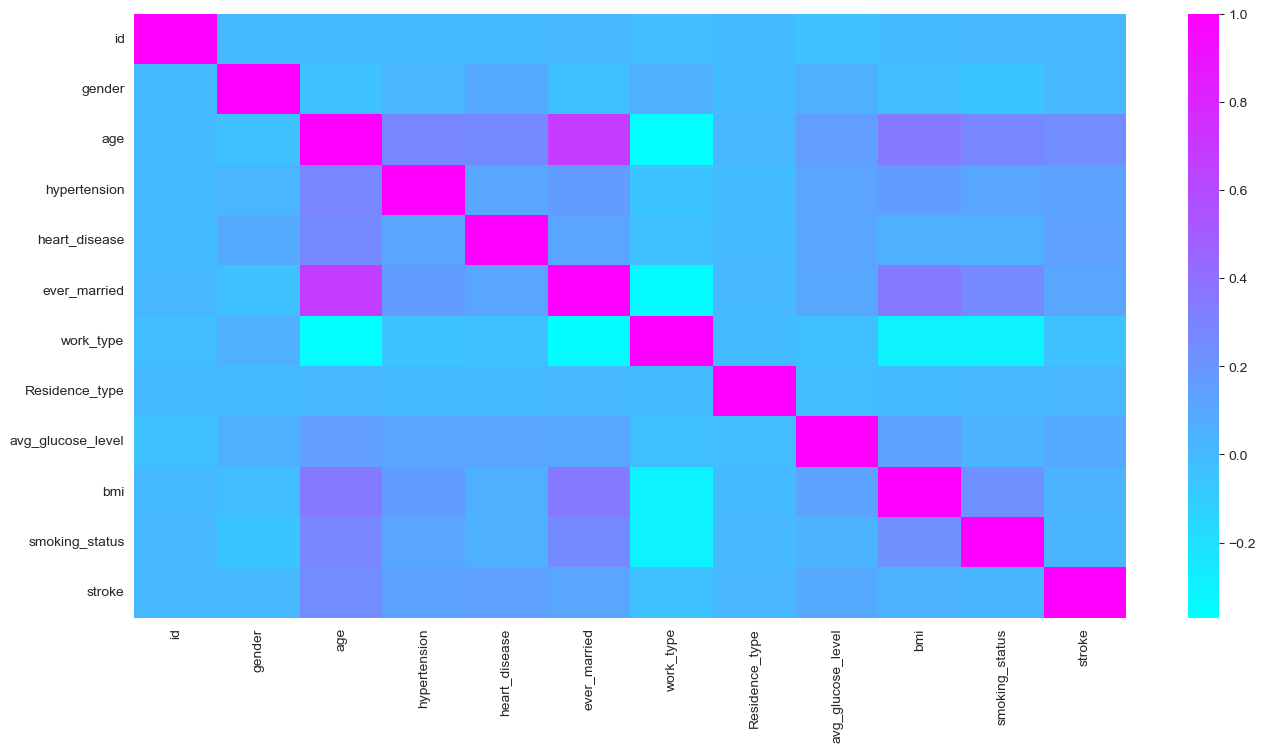

In [113]:
plt.figure(figsize = (16, 8), dpi = 100)
sns.heatmap(encoded_stroke_data.corr(), cmap = 'cool')
plt.show()

Feature ranking:
1. feature 2 (0.223985)
2. feature 8 (0.205180)
3. feature 0 (0.196518)
4. feature 9 (0.189016)
5. feature 6 (0.059211)
6. feature 1 (0.034038)
7. feature 7 (0.032944)
8. feature 3 (0.021849)
9. feature 4 (0.020177)
10. feature 5 (0.017083)


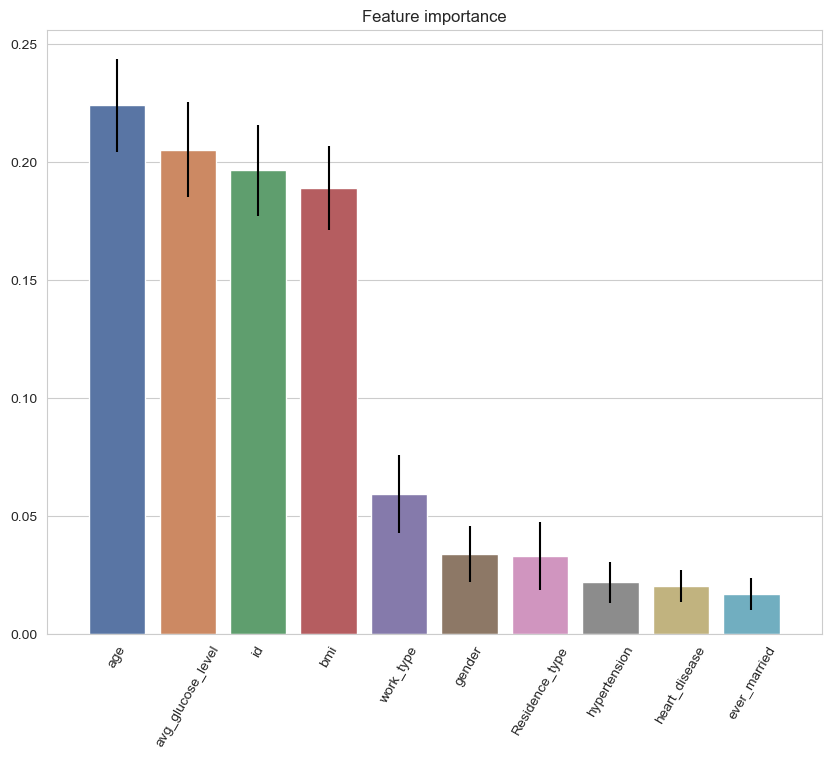

In [114]:
# Feature Importance
feas = encoded_stroke_data[features[: -1]]
labs = encoded_stroke_data['stroke']
forest = ExtraTreesClassifier(n_estimators = 250, random_state=0)
forest.fit(feas, labs)

importance = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importance)[::-1]

print("Feature ranking:")

for f in range(feas.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))

plt.figure(figsize = (10, 8), dpi = 100)
plt.title("Feature importance")
sns.barplot(x = np.array(features)[indices], y = importance[indices], palette = "deep",yerr = std[indices])
plt.xticks(range(feas.shape[1]), np.array(features[: -1])[indices], rotation = 60)
plt.xlim([-1, feas.shape[1]])
plt.show()

According to the correlation graph and feature importance graph, it's not hard to find that the target, stroke status, does not depend on gender, residence_type, and work_type that much, so we are good to drop these 3 features.

##### Drop the useless features and prepare the dataset for modelling

In [115]:
encoded_stroke_data.drop(['id', 'gender', 'Residence_type', 'work_type'], axis = 1, inplace = True)
encoded_stroke_data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
0,88,0,1,1,3850,349,1,1
1,82,0,0,1,3588,215,2,1
2,101,0,1,1,2483,294,2,1
3,70,0,0,1,3385,325,3,1
4,100,1,0,1,3394,127,2,1


In [116]:
X = encoded_stroke_data.iloc[:, : -1]
y = encoded_stroke_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

##### Apply PCA to get the features for modelling

In [117]:
# 2 components
pca_2 = PCA(n_components = 2)
# features after pca
components_2 = pca_2.fit_transform(X_train)

total_var = pca_2.explained_variance_ratio_.sum() * 100

fig_pca = px.scatter(components_2, x = 0, y = 1, color = y_train, size = 0.1 * np.ones(len(X_train)), opacity = 1,
                     title = f'Total Explained Variance: {total_var:.2f}%',
                     labels = {'0': 'PC 1', '1': 'PC 2'},
                     width = 800, height = 500)
fig_pca.show()

In [118]:
# 3 components
pca_3 = PCA(n_components = 3)
# features after pca
components_3 = pca_3.fit_transform(X_train)

total_var = pca_3.explained_variance_ratio_.sum() * 100

fig_pca = px.scatter_3d(components_3, x = 0, y = 1, z = 2, color = y_train, size = 0.1 * np.ones(len(X_train)), opacity = 1,
                        title = f'Total Explained Variance: {total_var:.2f}%',
                        labels = {'0': 'PC 1', '1': 'PC 2', '2': 'PC3'},
                        width = 800, height = 500)
fig_pca.show()

In [119]:
# 4 components
pca_4 = PCA(n_components = 4)
# features after pca
components_4 = pca_4.fit_transform(X_train)

## Model Selection